In [1]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

Using TensorFlow backend.


In [2]:
DATA_PATH = "/home/daniel/data/"

In [3]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [4]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

In [29]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3] #downsampling, 
    mfcc = librosa.feature.mfcc(wave,sr=22050, n_mfcc=13)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [30]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

In [31]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [32]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 13
channel = 1
epochs = 25
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [33]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [34]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [35]:
model13 = model_lenet()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 7s 272us/step - loss: 1.9861 - acc: 0.4376 - val_loss: 1.3001 - val_acc: 0.5954
Epoch 2/25
27200/27200 [==============================] - 6s 205us/step - loss: 0.9913 - acc: 0.6940 - val_loss: 0.8310 - val_acc: 0.7413
Epoch 3/25
27200/27200 [==============================] - 6s 206us/step - loss: 0.7494 - acc: 0.7654 - val_loss: 0.8805 - val_acc: 0.7375
Epoch 4/25
27200/27200 [==============================] - 6s 206us/step - loss: 0.6201 - acc: 0.8032 - val_loss: 0.7565 - val_acc: 0.7663
Epoch 5/25
27200/27200 [==============================] - 6s 214us/step - loss: 0.5348 - acc: 0.8274 - val_loss: 0.6994 - val_acc: 0.7876
Epoch 6/25
27200/27200 [==============================] - 6s 206us/step - loss: 0.4481 - acc: 0.8551 - val_loss: 0.6644 - val_acc: 0.8001
Epoch 7/25
27200/27200 [==============================] - 6s 210us/step - loss: 0.3976 - acc: 0.8701 - val_loss: 0.6647 - v

In [26]:
model20 = model_lenet()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 368us/step - loss: 2.0468 - acc: 0.4487 - val_loss: 1.1870 - val_acc: 0.6278
Epoch 2/25
27200/27200 [==============================] - 11s 402us/step - loss: 0.9348 - acc: 0.7082 - val_loss: 0.8814 - val_acc: 0.7278
Epoch 3/25
27200/27200 [==============================] - 10s 372us/step - loss: 0.6756 - acc: 0.7894 - val_loss: 0.8135 - val_acc: 0.7456
Epoch 4/25
27200/27200 [==============================] - 9s 349us/step - loss: 0.5379 - acc: 0.8292 - val_loss: 0.7048 - val_acc: 0.7853
Epoch 5/25
27200/27200 [==============================] - 11s 405us/step - loss: 0.4224 - acc: 0.8644 - val_loss: 0.7126 - val_acc: 0.7941
Epoch 6/25
27200/27200 [==============================] - 9s 349us/step - loss: 0.3351 - acc: 0.8918 - val_loss: 0.7389 - val_acc: 0.7899
Epoch 7/25
27200/27200 [==============================] - 11s 398us/step - loss: 0.2679 - acc: 0.9117 - val_loss: 0.714

In [12]:
model26 = model_lenet()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 13s 471us/step - loss: 1.9728 - acc: 0.4579 - val_loss: 1.0695 - val_acc: 0.6721
Epoch 2/25
27200/27200 [==============================] - 11s 407us/step - loss: 0.9207 - acc: 0.7135 - val_loss: 0.8592 - val_acc: 0.7334
Epoch 3/25
27200/27200 [==============================] - 12s 456us/step - loss: 0.6632 - acc: 0.7915 - val_loss: 0.7704 - val_acc: 0.7669
Epoch 4/25
27200/27200 [==============================] - 11s 418us/step - loss: 0.5013 - acc: 0.8402 - val_loss: 0.7064 - val_acc: 0.7885
Epoch 5/25
27200/27200 [==============================] - 13s 470us/step - loss: 0.4000 - acc: 0.8712 - val_loss: 0.7020 - val_acc: 0.7960
Epoch 6/25
27200/27200 [==============================] - 16s 571us/step - loss: 0.3048 - acc: 0.8988 - val_loss: 0.6922 - val_acc: 0.8060
Epoch 7/25
27200/27200 [==============================] - 13s 469us/step - loss: 0.2439 - acc: 0.9195 - val_loss: 0.7

In [69]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [39]:
model13 = model_spnet()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 8s 302us/step - loss: 2.3699 - acc: 0.2648 - val_loss: 1.7557 - val_acc: 0.4374
Epoch 2/25
27200/27200 [==============================] - 8s 276us/step - loss: 1.4130 - acc: 0.5552 - val_loss: 1.0622 - val_acc: 0.6635
Epoch 3/25
27200/27200 [==============================] - 8s 303us/step - loss: 1.0465 - acc: 0.6698 - val_loss: 0.9336 - val_acc: 0.7063
Epoch 4/25
27200/27200 [==============================] - 8s 308us/step - loss: 0.8750 - acc: 0.7221 - val_loss: 0.8925 - val_acc: 0.7229
Epoch 5/25
27200/27200 [==============================] - 8s 277us/step - loss: 0.7709 - acc: 0.7553 - val_loss: 0.8223 - val_acc: 0.7490
Epoch 6/25
27200/27200 [==============================] - 8s 285us/step - loss: 0.7078 - acc: 0.7755 - val_loss: 0.8271 - val_acc: 0.7399
Epoch 7/25
27200/27200 [==============================] - 8s 285us/step - loss: 0.6587 - acc: 0.7907 - val_loss: 0.7343 - v

In [11]:
model20 = model_spnet()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 13s 479us/step - loss: 2.3088 - acc: 0.2845 - val_loss: 1.7398 - val_acc: 0.4566
Epoch 2/25
27200/27200 [==============================] - 11s 397us/step - loss: 1.3063 - acc: 0.5868 - val_loss: 1.0399 - val_acc: 0.6699
Epoch 3/25
27200/27200 [==============================] - 12s 439us/step - loss: 0.9376 - acc: 0.7050 - val_loss: 0.9619 - val_acc: 0.7075
Epoch 4/25
27200/27200 [==============================] - 11s 408us/step - loss: 0.7853 - acc: 0.7552 - val_loss: 0.8058 - val_acc: 0.7497
Epoch 5/25
27200/27200 [==============================] - 12s 438us/step - loss: 0.6782 - acc: 0.7864 - val_loss: 0.7893 - val_acc: 0.7581
Epoch 6/25
27200/27200 [==============================] - 12s 440us/step - loss: 0.6178 - acc: 0.8036 - val_loss: 0.8834 - val_acc: 0.7369
Epoch 7/25
27200/27200 [==============================] - 11s 407us/step - loss: 0.5590 - acc: 0.8206 - val_loss: 0.6

In [54]:
model26 = model_spnet()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 16s 578us/step - loss: 2.3838 - acc: 0.2635 - val_loss: 1.6887 - val_acc: 0.4504
Epoch 2/25
27200/27200 [==============================] - 14s 517us/step - loss: 1.3800 - acc: 0.5595 - val_loss: 1.1711 - val_acc: 0.6324
Epoch 3/25
27200/27200 [==============================] - 16s 592us/step - loss: 0.9898 - acc: 0.6887 - val_loss: 0.9036 - val_acc: 0.7182
Epoch 4/25
27200/27200 [==============================] - 17s 628us/step - loss: 0.8207 - acc: 0.7418 - val_loss: 0.8048 - val_acc: 0.7476
Epoch 5/25
27200/27200 [==============================] - 19s 713us/step - loss: 0.7021 - acc: 0.7775 - val_loss: 0.7576 - val_acc: 0.7662
Epoch 6/25
27200/27200 [==============================] - 15s 563us/step - loss: 0.6384 - acc: 0.8002 - val_loss: 0.7258 - val_acc: 0.7749
Epoch 7/25
27200/27200 [==============================] - 16s 604us/step - loss: 0.5732 - acc: 0.8206 - val_loss: 0.7

In [74]:
def model_spnet2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Conv2D(50, kernel_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [41]:
model13 = model_spnet2()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 6s 209us/step - loss: 2.7862 - acc: 0.1771 - val_loss: 2.1823 - val_acc: 0.3109
Epoch 2/25
27200/27200 [==============================] - 6s 210us/step - loss: 2.0087 - acc: 0.3707 - val_loss: 1.8195 - val_acc: 0.4222
Epoch 3/25
27200/27200 [==============================] - 5s 181us/step - loss: 1.6870 - acc: 0.4696 - val_loss: 1.6139 - val_acc: 0.4931
Epoch 4/25
27200/27200 [==============================] - 5s 183us/step - loss: 1.4817 - acc: 0.5327 - val_loss: 1.3839 - val_acc: 0.5604
Epoch 5/25
27200/27200 [==============================] - 5s 193us/step - loss: 1.3498 - acc: 0.5764 - val_loss: 1.3188 - val_acc: 0.5881
Epoch 6/25
27200/27200 [==============================] - 5s 191us/step - loss: 1.2398 - acc: 0.6081 - val_loss: 1.2913 - val_acc: 0.5934
Epoch 7/25
27200/27200 [==============================] - 5s 189us/step - loss: 1.1753 - acc: 0.6264 - val_loss: 1.2446 - v

In [13]:
model20 = model_spnet2()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 359us/step - loss: 3.2945 - acc: 0.1978 - val_loss: 2.0767 - val_acc: 0.3543
Epoch 2/25
27200/27200 [==============================] - 9s 326us/step - loss: 1.8901 - acc: 0.4147 - val_loss: 1.6500 - val_acc: 0.4888
Epoch 3/25
27200/27200 [==============================] - 9s 348us/step - loss: 1.5344 - acc: 0.5235 - val_loss: 1.3886 - val_acc: 0.5579
Epoch 4/25
27200/27200 [==============================] - 9s 336us/step - loss: 1.3292 - acc: 0.5869 - val_loss: 1.4646 - val_acc: 0.5409
Epoch 5/25
27200/27200 [==============================] - 9s 320us/step - loss: 1.2005 - acc: 0.6253 - val_loss: 1.1842 - val_acc: 0.6341
Epoch 6/25
27200/27200 [==============================] - 9s 313us/step - loss: 1.1038 - acc: 0.6548 - val_loss: 1.1475 - val_acc: 0.6406
Epoch 7/25
27200/27200 [==============================] - 9s 340us/step - loss: 1.0257 - acc: 0.6807 - val_loss: 1.1150 - 

In [56]:
model26 = model_spnet2()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 8s 310us/step - loss: 2.8062 - acc: 0.2125 - val_loss: 2.0745 - val_acc: 0.3316
Epoch 2/25
27200/27200 [==============================] - 8s 282us/step - loss: 1.8486 - acc: 0.4147 - val_loss: 1.7484 - val_acc: 0.4343
Epoch 3/25
27200/27200 [==============================] - 9s 330us/step - loss: 1.4802 - acc: 0.5322 - val_loss: 1.5198 - val_acc: 0.5372
Epoch 4/25
27200/27200 [==============================] - 8s 288us/step - loss: 1.2739 - acc: 0.5969 - val_loss: 1.3293 - val_acc: 0.5903
Epoch 5/25
27200/27200 [==============================] - 9s 347us/step - loss: 1.1339 - acc: 0.6430 - val_loss: 1.3139 - val_acc: 0.5896
Epoch 6/25
27200/27200 [==============================] - 9s 324us/step - loss: 1.0222 - acc: 0.6730 - val_loss: 1.1224 - val_acc: 0.6534
Epoch 7/25
27200/27200 [==============================] - 9s 345us/step - loss: 0.9506 - acc: 0.6998 - val_loss: 1.0289 - v

In [27]:
def model_spnet3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [43]:
model13 = model_spnet3()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 9s 342us/step - loss: 2.7971 - acc: 0.2563 - val_loss: 1.7387 - val_acc: 0.4546
Epoch 2/25
27200/27200 [==============================] - 9s 348us/step - loss: 1.4898 - acc: 0.5404 - val_loss: 1.4568 - val_acc: 0.5575
Epoch 3/25
27200/27200 [==============================] - 9s 332us/step - loss: 1.1135 - acc: 0.6522 - val_loss: 1.0192 - val_acc: 0.6838
Epoch 4/25
27200/27200 [==============================] - 9s 325us/step - loss: 0.9248 - acc: 0.7137 - val_loss: 1.0792 - val_acc: 0.6726
Epoch 5/25
27200/27200 [==============================] - 9s 349us/step - loss: 0.8054 - acc: 0.7487 - val_loss: 0.8977 - val_acc: 0.7249
Epoch 6/25
27200/27200 [==============================] - 10s 361us/step - loss: 0.7245 - acc: 0.7720 - val_loss: 0.7742 - val_acc: 0.7615
Epoch 7/25
27200/27200 [==============================] - 10s 370us/step - loss: 0.6518 - acc: 0.7940 - val_loss: 0.8827 -

In [28]:
model20 = model_spnet3()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 15s 546us/step - loss: 2.7685 - acc: 0.2657 - val_loss: 1.7727 - val_acc: 0.4478
Epoch 2/25
27200/27200 [==============================] - 14s 507us/step - loss: 1.5121 - acc: 0.5290 - val_loss: 1.5148 - val_acc: 0.5331
Epoch 3/25
27200/27200 [==============================] - 14s 519us/step - loss: 1.1448 - acc: 0.6441 - val_loss: 1.1323 - val_acc: 0.6443
Epoch 4/25
27200/27200 [==============================] - 14s 530us/step - loss: 0.9401 - acc: 0.7033 - val_loss: 0.8627 - val_acc: 0.7322
Epoch 5/25
27200/27200 [==============================] - 16s 582us/step - loss: 0.8111 - acc: 0.7471 - val_loss: 0.8817 - val_acc: 0.7291
Epoch 6/25
27200/27200 [==============================] - 15s 554us/step - loss: 0.7222 - acc: 0.7728 - val_loss: 0.8730 - val_acc: 0.7326
Epoch 7/25
27200/27200 [==============================] - 15s 568us/step - loss: 0.6456 - acc: 0.7953 - val_loss: 0.7

In [15]:
model26 = model_spnet3()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 18s 659us/step - loss: 5.3215 - acc: 0.1829 - val_loss: 1.8196 - val_acc: 0.4418
Epoch 2/25
27200/27200 [==============================] - 17s 613us/step - loss: 1.6489 - acc: 0.4871 - val_loss: 1.4021 - val_acc: 0.5456
Epoch 3/25
27200/27200 [==============================] - 19s 692us/step - loss: 1.1944 - acc: 0.6254 - val_loss: 1.1350 - val_acc: 0.6438
Epoch 4/25
27200/27200 [==============================] - 17s 611us/step - loss: 0.9652 - acc: 0.6973 - val_loss: 1.0271 - val_acc: 0.6781
Epoch 5/25
27200/27200 [==============================] - 17s 613us/step - loss: 0.8258 - acc: 0.7401 - val_loss: 0.8822 - val_acc: 0.7250
Epoch 6/25
27200/27200 [==============================] - 19s 685us/step - loss: 0.7277 - acc: 0.7687 - val_loss: 0.8767 - val_acc: 0.7285
Epoch 7/25
27200/27200 [==============================] - 19s 688us/step - loss: 0.6399 - acc: 0.7969 - val_loss: 0.8

In [16]:
def model_spnet4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4), strides=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [45]:
model13 = model_spnet4()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 18s 654us/step - loss: 2.4992 - acc: 0.3001 - val_loss: 1.3191 - val_acc: 0.5838
Epoch 2/25
27200/27200 [==============================] - 15s 546us/step - loss: 1.2986 - acc: 0.5964 - val_loss: 0.9989 - val_acc: 0.6807
Epoch 3/25
27200/27200 [==============================] - 15s 549us/step - loss: 0.9199 - acc: 0.7108 - val_loss: 0.7384 - val_acc: 0.7693
Epoch 4/25
27200/27200 [==============================] - 15s 547us/step - loss: 0.7604 - acc: 0.7605 - val_loss: 0.7576 - val_acc: 0.7725
Epoch 5/25
27200/27200 [==============================] - 15s 548us/step - loss: 0.6562 - acc: 0.7926 - val_loss: 0.8204 - val_acc: 0.7541
Epoch 6/25
27200/27200 [==============================] - 18s 668us/step - loss: 0.5913 - acc: 0.8146 - val_loss: 0.6490 - val_acc: 0.8021
Epoch 7/25
27200/27200 [==============================] - 17s 634us/step - loss: 0.5101 - acc: 0.8364 - val_loss: 0.8

In [17]:
model20 = model_spnet4()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 20s 727us/step - loss: 3.6287 - acc: 0.2628 - val_loss: 1.5496 - val_acc: 0.5029
Epoch 2/25
27200/27200 [==============================] - 20s 725us/step - loss: 1.2677 - acc: 0.6039 - val_loss: 1.0486 - val_acc: 0.6762
Epoch 3/25
27200/27200 [==============================] - 20s 740us/step - loss: 0.8885 - acc: 0.7224 - val_loss: 0.8832 - val_acc: 0.7238
Epoch 4/25
27200/27200 [==============================] - 21s 776us/step - loss: 0.7033 - acc: 0.7809 - val_loss: 0.7298 - val_acc: 0.7751
Epoch 5/25
27200/27200 [==============================] - 19s 716us/step - loss: 0.5964 - acc: 0.8108 - val_loss: 0.7193 - val_acc: 0.7868
Epoch 6/25
27200/27200 [==============================] - 21s 755us/step - loss: 0.5215 - acc: 0.8343 - val_loss: 0.6752 - val_acc: 0.8043
Epoch 7/25
27200/27200 [==============================] - 21s 755us/step - loss: 0.4560 - acc: 0.8540 - val_loss: 0.6

In [17]:
model26 = model_spnet4()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 28s 1ms/step - loss: 3.1933 - acc: 0.2724 - val_loss: 1.7120 - val_acc: 0.4793
Epoch 2/25
27200/27200 [==============================] - 25s 910us/step - loss: 1.2499 - acc: 0.6100 - val_loss: 0.9231 - val_acc: 0.7093
Epoch 3/25
27200/27200 [==============================] - 26s 968us/step - loss: 0.8523 - acc: 0.7308 - val_loss: 0.8643 - val_acc: 0.7363
Epoch 4/25
27200/27200 [==============================] - 26s 948us/step - loss: 0.6947 - acc: 0.7804 - val_loss: 0.7010 - val_acc: 0.7875
Epoch 5/25
27200/27200 [==============================] - 24s 877us/step - loss: 0.5792 - acc: 0.8166 - val_loss: 0.7284 - val_acc: 0.7747
Epoch 6/25
27200/27200 [==============================] - 26s 939us/step - loss: 0.5058 - acc: 0.8380 - val_loss: 0.6085 - val_acc: 0.8113
Epoch 7/25
27200/27200 [==============================] - 24s 896us/step - loss: 0.4358 - acc: 0.8596 - val_loss: 0.649

In [18]:
def model_spnet6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6),strides=1, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6), strides=1))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [47]:
model13 = model_spnet6()
model13.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 15s 559us/step - loss: 2.4705 - acc: 0.2908 - val_loss: 1.5043 - val_acc: 0.5247
Epoch 2/25
27200/27200 [==============================] - 15s 565us/step - loss: 1.3248 - acc: 0.5861 - val_loss: 1.5545 - val_acc: 0.5422
Epoch 3/25
27200/27200 [==============================] - 14s 513us/step - loss: 0.9625 - acc: 0.6969 - val_loss: 1.1109 - val_acc: 0.6628
Epoch 4/25
27200/27200 [==============================] - 15s 536us/step - loss: 0.7988 - acc: 0.7517 - val_loss: 1.1172 - val_acc: 0.6718
Epoch 5/25
27200/27200 [==============================] - 14s 501us/step - loss: 0.6904 - acc: 0.7810 - val_loss: 0.8413 - val_acc: 0.7451
Epoch 6/25
27200/27200 [==============================] - 14s 518us/step - loss: 0.6126 - acc: 0.8076 - val_loss: 0.7141 - val_acc: 0.7847
Epoch 7/25
27200/27200 [==============================] - 15s 534us/step - loss: 0.5604 - acc: 0.8253 - val_loss: 0.6

In [20]:
model20 = model_spnet6()
model20.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 23s 859us/step - loss: 2.3739 - acc: 0.2780 - val_loss: 1.8250 - val_acc: 0.4237
Epoch 2/25
27200/27200 [==============================] - 22s 811us/step - loss: 1.3013 - acc: 0.5892 - val_loss: 0.9460 - val_acc: 0.6999
Epoch 3/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.9265 - acc: 0.7094 - val_loss: 0.8411 - val_acc: 0.7371
Epoch 4/25
27200/27200 [==============================] - 26s 947us/step - loss: 0.7390 - acc: 0.7695 - val_loss: 0.7698 - val_acc: 0.7626
Epoch 5/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.6404 - acc: 0.7978 - val_loss: 0.8157 - val_acc: 0.7562
Epoch 6/25
27200/27200 [==============================] - 26s 960us/step - loss: 0.5624 - acc: 0.8230 - val_loss: 0.6342 - val_acc: 0.8054
Epoch 7/25
27200/27200 [==============================] - 28s 1ms/step - loss: 0.4995 - acc: 0.8381 - val_loss: 0.7484 - 

In [19]:
model26 = model_spnet6()
model26.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 31s 1ms/step - loss: 2.4172 - acc: 0.2698 - val_loss: 1.5337 - val_acc: 0.4985
Epoch 2/25
27200/27200 [==============================] - 31s 1ms/step - loss: 1.3346 - acc: 0.5718 - val_loss: 1.1521 - val_acc: 0.6291
Epoch 3/25
27200/27200 [==============================] - 31s 1ms/step - loss: 0.9560 - acc: 0.6988 - val_loss: 0.8599 - val_acc: 0.7259
Epoch 4/25
27200/27200 [==============================] - 31s 1ms/step - loss: 0.7378 - acc: 0.7643 - val_loss: 0.7917 - val_acc: 0.7535
Epoch 5/25
27200/27200 [==============================] - 32s 1ms/step - loss: 0.6457 - acc: 0.7951 - val_loss: 0.8254 - val_acc: 0.7572
Epoch 6/25
27200/27200 [==============================] - 38s 1ms/step - loss: 0.5635 - acc: 0.8214 - val_loss: 0.7040 - val_acc: 0.7869
Epoch 7/25
27200/27200 [==============================] - 39s 1ms/step - loss: 0.5057 - acc: 0.8398 - val_loss: 0.5954 - val_acc:

In [38]:
spnet13 = {}
lenet13 = {}
spnet13_k2 = {}
spnet13_k3 = {}
spnet13_k4 = {}
spnet13_k6 = {}

In [39]:
spnet13[1] = 0.2648; spnet13[5] = 0.7553; spnet13[10] = 0.8269; spnet13[15] = 0.8600; spnet13[20] = 0.8843; spnet13[25] = 0.9051; 

In [40]:
lenet13[1] = 0.4376; lenet13[5] = 0.8274; lenet13[10] = 0.9156; lenet13[15] = 0.9586; lenet13[20] = 0.9785; lenet13[25] = 0.9851; 

In [41]:
spnet13_k2[1] = 0.1771; spnet13_k2[5] = 0.5764; spnet13_k2[10] = 0.6819; spnet13_k2[15] = 0.7377; spnet13_k2[20] = 0.7696; spnet13_k2[25] = 0.7943; 

In [42]:
spnet13_k3[1] = 0.2563; spnet13_k3[5] = 0.7487; spnet13_k3[10] = 0.8386; spnet13_k3[15] = 0.8800; spnet13_k3[20] = 0.9139; spnet13_k3[25] = 0.9364; 

In [43]:
spnet13_k4[1] = 0.3001; spnet13_k4[5] = 0.7926; spnet13_k4[10] = 0.8725; spnet13_k4[15] = 0.9236; spnet13_k4[20] = 0.9450; spnet13_k4[25] = 0.9602; 

In [44]:
spnet13_k6[1] = 0.2908; spnet13_k6[5] = 0.7810; spnet13_k6[10] = 0.8622; spnet13_k6[15] = 0.9068; spnet13_k6[20] = 0.9310; spnet13_k6[25] = 0.9540; 

In [45]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),spnet13_k2.values(),spnet13_k3.values(),spnet13_k4.values(),spnet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 13

In [46]:
tabel_acc13

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.2648,0.4376,0.1771,0.2563,0.3001,0.2908
1,5.0,0.7553,0.8274,0.5764,0.7487,0.7926,0.7810
2,10.0,0.8269,0.9156,0.6819,0.8386,0.8725,0.8622
3,15.0,0.8600,0.9586,0.7377,0.8800,0.9236,0.9068
4,20.0,0.8843,0.9785,0.7696,0.9139,0.9450,0.9310
5,25.0,0.9051,0.9851,0.7943,0.9364,0.9602,0.9540


In [47]:
tabel_acc13_val = pd.DataFrame([0.8300,0.8169,0.7909,0.8375,0.8362,0.8346])
tabel_acc13_val = tabel_acc13_val.T
tabel_acc13_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## VALIDATION ACCURATION FOR COEFFICIENT 13

In [48]:
tabel_acc13_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.83,0.8169,0.7909,0.8375,0.8362,0.8346


In [49]:
spnet = {}
lenet = {}
spnet_k2 = {}
spnet_k3 = {}
spnet_k4 = {}
spnet_k6 = {}

In [50]:
spnet[1] = 0.2845; spnet[5] = 0.7864; spnet[10] = 0.8581; spnet[15] = 0.8993; spnet[20] = 0.9284; spnet[25] = 0.9472; 

In [51]:
lenet[1] = 0.4487; lenet[5] = 0.8644; lenet[10] = 0.9549; lenet[15] = 0.9792; lenet[20] = 0.9885; lenet[25] = 0.9882; 

In [52]:
spnet_k2[1] = 0.1978; spnet_k2[5] = 0.6253; spnet_k2[10] = 0.7306; spnet_k2[15] = 0.7838; spnet_k2[20] = 0.8112; spnet_k2[25] = 0.8468; 

In [53]:
spnet_k3[1] = 0.2657; spnet_k3[5] = 0.7471; spnet_k3[10] = 0.8416; spnet_k3[15] = 0.8951; spnet_k3[20] = 0.9296; spnet_k3[25] = 0.9528; 

In [54]:
spnet_k4[1] = 0.2628; spnet_k4[5] = 0.8108; spnet_k4[10] = 0.8961; spnet_k4[15] = 0.9350; spnet_k4[20] = 0.9598; spnet_k4[25] = 0.9653; 

In [55]:
spnet_k6[1] = 0.2780; spnet_k6[5] = 0.7978; spnet_k6[10] = 0.8851; spnet_k6[15] = 0.9271; spnet_k6[20] = 0.9508; spnet_k6[25] = 0.9638; 

In [56]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),spnet_k2.values(),spnet_k3.values(),spnet_k4.values(),spnet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR KOEFISIEN 20

In [57]:
tabel_acc20

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.2845,0.4487,0.1978,0.2657,0.2628,0.2780
1,5.0,0.7864,0.8644,0.6253,0.7471,0.8108,0.7978
2,10.0,0.8581,0.9549,0.7306,0.8416,0.8961,0.8851
3,15.0,0.8993,0.9792,0.7838,0.8951,0.9350,0.9271
4,20.0,0.9284,0.9885,0.8112,0.9296,0.9598,0.9508
5,25.0,0.9472,0.9882,0.8468,0.9528,0.9653,0.9638


In [59]:
tabel_acc20_val = pd.DataFrame([0.8213,0.8200,0.8015,0.8096,0.8416,0.8362])
tabel_acc20_val = tabel_acc20_val.T
tabel_acc20_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## VALIDATION ACCURATION FOR COEFFICIENT 20

In [60]:
tabel_acc20_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.8213,0.82,0.8015,0.8096,0.8416,0.8362


In [61]:
spnet26 = {}
lenet26 = {}
spnet26_k2 = {}
spnet26_k3 = {}
spnet26_k4 = {}
spnet26_k6 = {}

In [62]:
spnet26[1] = 0.2635; spnet26[5] = 0.7775; spnet26[10] = 0.8577; spnet26[15] = 0.8991; spnet26[20] = 0.9262; spnet26[25] = 0.9459; 

In [63]:
lenet26[1] = 0.4579; lenet26[5] = 0.8712; lenet26[10] = 0.9612; lenet26[15] = 0.9831; lenet26[20] = 0.9881; lenet26[25] = 0.9896;

In [64]:
spnet26_k2[1] = 0.2125; spnet26_k2[5] = 0.6430; spnet26_k2[10] = 0.7509; spnet26_k2[15] = 0.8048; spnet26_k2[20] = 0.8412; spnet26_k2[25] = 0.8742; 

In [65]:
spnet26_k3[1] = 0.1829; spnet26_k3[5] = 0.7401; spnet26_k3[10] = 0.8497; spnet26_k3[15] = 0.9056; spnet26_k3[20] = 0.9400; spnet26_k3[25] = 0.9626; 

In [66]:
spnet26_k4[1] = 0.2724; spnet26_k4[5] = 0.8166; spnet26_k4[10] = 0.9042; spnet26_k4[15] = 0.9455; spnet26_k4[20] = 0.9614; spnet26_k4[25] = 0.9725; 

In [67]:
spnet26_k6[1] = 0.2698; spnet26_k6[5] = 0.7951; spnet26_k6[10] = 0.8846; spnet26_k6[15] = 0.9292; spnet26_k6[20] = 0.9527; spnet26_k6[25] = 0.9656; 

In [68]:
tabel_acc26 = pd.DataFrame([spnet26.keys(),spnet26.values(),lenet26.values(),spnet26_k2.values(),spnet26_k3.values(),spnet26_k4.values(),spnet26_k6.values()])
tabel_acc26 = tabel_acc26.T
tabel_acc26.columns = ['number of epoch','SPNet','Lenet','SPnet k=2x2','SPnet k=3x3','SPnet k=4x4','SPnet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 26

In [69]:
tabel_acc26

,number of epoch,SPNet,Lenet,SPnet k=2x2,SPnet k=3x3,SPnet k=4x4,SPnet k=6x6
0,1.0,0.2635,0.4579,0.2125,0.1829,0.2724,0.2698
1,5.0,0.7775,0.8712,0.6430,0.7401,0.8166,0.7951
2,10.0,0.8577,0.9612,0.7509,0.8497,0.9042,0.8846
3,15.0,0.8991,0.9831,0.8048,0.9056,0.9455,0.9292
4,20.0,0.9262,0.9881,0.8412,0.9400,0.9614,0.9527
5,25.0,0.9459,0.9896,0.8742,0.9626,0.9725,0.9656


In [70]:
tabel_acc26_val = pd.DataFrame([0.8229,0.8251,0.7976,0.8019,0.8493,0.8431])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## VALIDATION ACCURATION FOR COEFFICIENT 26

In [71]:
tabel_acc26_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.8229,0.8251,0.7976,0.8019,0.8493,0.8431


In [72]:
sp_graph = {}
lenet_graph = {}
spnet2_graph = {}
spnet3_graph = {}
spnet4_graph = {}
spnet6_graph = {}
sp_graph[13] = 0.83; lenet_graph[13] = 0.8169; spnet2_graph[13] = 0.7909; spnet3_graph[13] = 0.8375; spnet4_graph[13] = 0.8362; spnet6_graph[13] = 0.8346;
sp_graph[20] = 0.8213; lenet_graph[20] = 0.82; spnet2_graph[20] = 0.8015; spnet3_graph[20] = 0.8096; spnet4_graph[20] = 0.8416; spnet6_graph[20] = 0.8362;
sp_graph[26] = 0.8229; lenet_graph[26] = 0.8251; spnet2_graph[26] = 0.7976; spnet3_graph[26] = 0.8019; spnet4_graph[26] = 0.8493; spnet6_graph[26] = 0.8431;

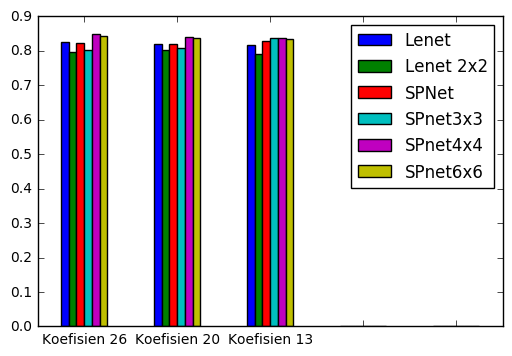

In [73]:
sp = [sp_graph[26],sp_graph[20],sp_graph[13],0,0]
le = [lenet_graph[26],lenet_graph[20],lenet_graph[13],0,0]
sp2 = [spnet2_graph[26],spnet2_graph[20],spnet2_graph[13],0,0]
sp3 = [spnet3_graph[26],spnet3_graph[20],spnet3_graph[13],0,0]
sp4 = [spnet4_graph[26],spnet4_graph[20],spnet4_graph[13],0,0]
sp6 = [spnet6_graph[26],spnet6_graph[20],spnet6_graph[13],0,0]
index = ["Koefisien 26",'Koefisien 20','Koefisien 13','','']
df = pd.DataFrame({'SPNet': sp,'Lenet': le,'Lenet 2x2': sp2,'SPnet3x3': sp3,'SPnet4x4': sp4,'SPnet6x6': sp6}, index=index)
ax = df.plot.bar(rot=0)
plt.show()

In [74]:
tp = {}
fp = {}
fn = {}

In [23]:
for i in labels:
    tp[i] = 0
    fp[i] = 0
    fn[i] = 0

In [24]:
count = 0
for i in range(0,6800):
    sample = X_test[i].reshape(1, feature_dim_1, feature_dim_2, channel)
    prediction = get_labels()[0][np.argmax(model20.predict(sample))]
    real = get_labels()[0][np.argmax(y_test_hot[i])]
    if (real == prediction):
        count+=1
        tp[real]+=1
    else:
        fn[prediction]+=1
        fp[real]+=1

In [26]:
precision = {}
recall = {}
f1 = {}
accurationn = {}
error_rate = {}
for i in labels:
    precision[i] = 0
    recall[i] = 0
    f1[i] = 0
    error_rate[i] = 0

In [27]:
from __future__ import division
for i in labels:
    precision[i] = tp[i]/(tp[i]+fp[i])
    recall[i] = tp[i]/(tp[i]+fn[i])
    f1[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
    error_rate[i] = 1-precision[i]

In [28]:
tabel_acc26_val = pd.DataFrame([precision.keys(),precision.values(),recall.values(),f1.values(),error_rate.values()])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['Label', 'Precision / Accuration', 'Recall', 'F - Measure','Error Rate']

In [29]:
tabel_acc26_val

,Label,Precision / Accuration,Recall,F - Measure,Error Rate
0,sheila,0.9125,0.848837,0.879518,0.0875
1,seven,0.751534,0.847751,0.796748,0.248466
2,right,0.810398,0.777126,0.793413,0.189602
3,three,0.907514,0.850949,0.878322,0.0924855
4,no,0.813031,0.841642,0.827089,0.186969
5,marvin,0.895833,0.901198,0.898507,0.104167
6,wow,0.926346,0.786058,0.850455,0.0736544
7,six,0.864706,0.854651,0.859649,0.135294
8,stop,0.815013,0.808511,0.811749,0.184987
9,up,0.753754,0.814935,0.783151,0.246246


In [32]:
print(predict('/home/daniel/datatest/dogg.wav', model=model20))

no
